# **TASK NO 5**

**Flower Classification- Dataset: Use the Flowers Recognition dataset available from Kaggle, containing images of flowers categorized into
different classes (e.g., daisy, tulip, rose, sunflower). Use any Supervised Algorithm to Perform Classification and Use Stramlit to Give the UI to the Classification Task.**

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import datasets,layers,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D
from zipfile import ZipFile
import os,glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.models import Model
from sklearn import preprocessing
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import BatchNormalization
from zipfile import ZipFile
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from PIL import Image

# **Downloading the Dataset**

In [20]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [21]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Extracting the Data**

In [22]:
file = "/content/flowers-recognition.zip"
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('Sucessfull')

Sucessfull


In [23]:
daisy = '/content/flowers/daisy'
dandelion = '/content/flowers/dandelion'
rose = '/content/flowers/rose'
sunflower = '/content/flowers/sunflower'
tulip = '/content/flowers/tulip'

print(f"Number of daisy Images in dataset: {len(daisy)}")
print(f"Number of dandelion Images in dataset: {len(dandelion)}")
print(f"Number of rose Images in dataset: {len(rose)}")
print(f"Number of sunflower Images in dataset: {len(sunflower)}")
print(f"Number of tulip Images in dataset: {len(tulip)}")

Number of daisy Images in dataset: 22
Number of dandelion Images in dataset: 26
Number of rose Images in dataset: 21
Number of sunflower Images in dataset: 26
Number of tulip Images in dataset: 22


In [24]:
x = []
y = []

labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
img_size = 224

# Load training data
for label in labels:
    train_folder_path = os.path.join('/content/flowers', label)
    for filename in os.listdir(train_folder_path):
        img = cv2.imread(os.path.join(train_folder_path, filename))
        img = cv2.resize(img, (img_size, img_size))
        x.append(img)
        y.append(label)
x = np.array(x)
y = np.array(y)

In [25]:
print(len(x))
print(len(y))

4317
4317


# **Shuffling the data**

In [26]:
x,y = shuffle(x,y,random_state=101)

In [27]:
print(f"Shape of X: {x.shape}")
print(f"Shape of Y: {y.shape}")

Shape of X: (4317, 224, 224, 3)
Shape of Y: (4317,)


# **Display some images**

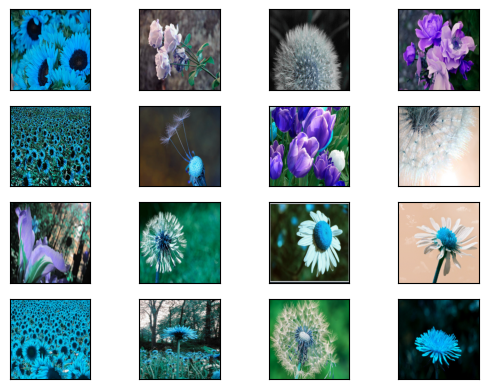

In [28]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x[i],cmap=plt.cm.binary)

In [29]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

In [30]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (3453, 224, 224, 3)
Shape of x_test: (864, 224, 224, 3)
Shape of y_train: (3453,)
Shape of y_test: (864,)


In [31]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [38]:
len(labels)

5

# **Building Neural Network**

# **Using VGG16**

In [39]:
from keras.applications import vgg16

In [41]:
r , c = 224 , 224
vgg = vgg16.VGG16(weights = 'imagenet', include_top = False,input_shape=(r,c,3))
for layer in vgg.layers:
    layer.trainable = False

In [42]:
def add_on_layers(class_num,model):
  top_model=model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(512,activation='relu')(top_model)
  top_model = Dense(64,activation='relu')(top_model)
  top_model = Dropout(0.3)(top_model)
  top_model = Dense(32,activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
  top_model = Dense(5,activation='softmax')(top_model)
  return top_model

In [44]:
head = add_on_layers(5,vgg)
model = Model(inputs=vgg.input,outputs=head)

In [45]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# **Compiling the Model**

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics= ['accuracy'])

# **Fitting the Model**

In [47]:
model.fit(x_train,y_train,epochs=10,validation_split=0.1)

Epoch 1/10
98/98 [==============================] - 2328s 24s/step - loss: 1.2493 - accuracy: 0.5143 - val_loss: 0.6355 - val_accuracy: 0.7948
Epoch 2/10
98/98 [==============================] - 2106s 22s/step - loss: 0.7435 - accuracy: 0.7129 - val_loss: 0.5247 - val_accuracy: 0.8092
Epoch 3/10
98/98 [==============================] - 2036s 21s/step - loss: 0.5649 - accuracy: 0.7837 - val_loss: 0.4887 - val_accuracy: 0.8324
Epoch 4/10
98/98 [==============================] - 2032s 21s/step - loss: 0.4986 - accuracy: 0.8159 - val_loss: 0.4556 - val_accuracy: 0.8642
Epoch 5/10
98/98 [==============================] - 2033s 21s/step - loss: 0.4218 - accuracy: 0.8516 - val_loss: 0.4629 - val_accuracy: 0.8728
Epoch 6/10
98/98 [==============================] - 2105s 21s/step - loss: 0.3550 - accuracy: 0.8716 - val_loss: 0.4356 - val_accuracy: 0.8555
Epoch 7/10
98/98 [==============================] - 2093s 21s/step - loss: 0.3186 - accuracy: 0.8828 - val_loss: 0.4558 - val_accuracy: 0.8671

In [48]:
loss , acc = model.evaluate(x_test,y_test)
print(f"Accuracy on test data: {acc*100:0.2f}%")

27/27 [==============================] - 542s 20s/step - loss: 0.4277 - accuracy: 0.8553
Accuracy on test data: 85.53%


# **Making Prediction**

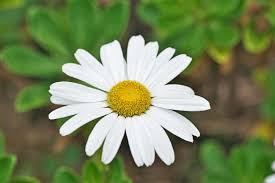

In [49]:
image1 = '/content/daisy_1.jpeg'
image1 = cv2.imread(image1)
cv2_imshow(image1)

In [50]:
image1 = cv2.resize(image1,(224,224))
image1 = np.reshape(image1,[1,224,224,3])

In [52]:
pred1 = model.predict(image1)
print(f"Prediction: {labels[np.argmax(pred1)]}")


1/1 [==============================] - 2s 2s/step
Prediction: daisy


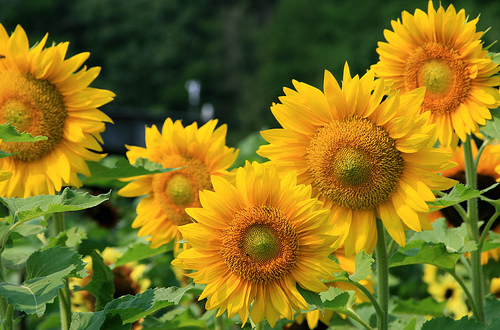

In [53]:
image2 = '/content/flowers/sunflower/1008566138_6927679c8a.jpg'
image2 = cv2.imread(image2)
cv2_imshow(image2)

In [54]:
image2 = cv2.resize(image2,(224,224))
image2 = np.reshape(image2,[1,224,224,3])

In [56]:
pred2 = model.predict(image2)
print(f"Prediction: {labels[np.argmax(pred2)]}")

1/1 [==============================] - 1s 1s/step
Prediction: sunflower


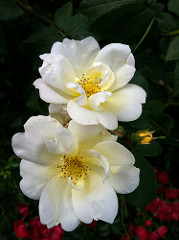

In [57]:
image3 = '/content/flowers/rose/10090824183_d02c613f10_m.jpg'
image3 = cv2.imread(image3)
cv2_imshow(image3)
image3 = cv2.resize(image3,(224,224))
image3 = np.reshape(image3,[1,224,224,3])

In [59]:
pred3 = model.predict(image3)
print(f"Prediction: {labels[np.argmax(pred3)]}")

1/1 [==============================] - 1s 815ms/step
Prediction: rose


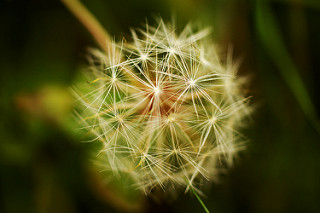

In [60]:
image4 = '/content/flowers/dandelion/10043234166_e6dd915111_n.jpg'
image4 = cv2.imread(image4)
cv2_imshow(image4)
image4 = cv2.resize(image4,(224,224))
image4 = np.reshape(image4,[1,224,224,3])

In [61]:
pred4 = model.predict(image4)
print(f"Prediction: {labels[np.argmax(pred4)]}")

1/1 [==============================] - 1s 943ms/step
Prediction: dandelion


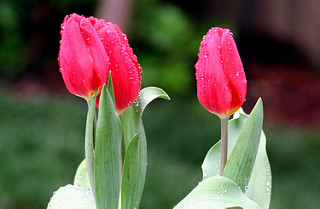

In [62]:
image5 = '/content/flowers/tulip/100930342_92e8746431_n.jpg'
image5 = cv2.imread(image5)
cv2_imshow(image5)
image5 = cv2.resize(image5,(224,224))
image5 = np.reshape(image5,[1,224,224,3])

In [63]:
pred5 = model.predict(image5)
print(f"Prediction: {labels[np.argmax(pred5)]}")

1/1 [==============================] - 1s 1s/step
Prediction: tulip


# **Saving the Model**

In [64]:
model.save('Flower.h5')
from tensorflow.keras.models import load_model

loaded_model = load_model('Flower.h5')

tf.saved_model.save(loaded_model,'Flower_tf_2.16.1')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
! zip -r '/content/Flower_tf_2.16.1.zip/content/Flower_tf_2.16.1'


zip error: Nothing to do! (/content/Flower_tf_2.16.1.zip/content/Flower_tf_2.16.1)


In [66]:
from google.colab import files
files.download('/content/Flower_tf_2.16.1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
%cd '/content/Flower_tf_2.16.1'

/content/Flower_tf_2.16.1


In [73]:
! zip -r '/content/Flower_tf_2.16.1.zip/content/Flower_tf_2.16.1'


zip error: Nothing to do! (/content/Flower_tf_2.16.1.zip/content/Flower_tf_2.16.1)


In [74]:
from google.colab import files
files.download('/content/Flower_tf_2.16.1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>